# Machine Learning Assignment

This notebook contains the required sections for your ML assignment, including dataset analysis and visualizations.

## Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [2]:
# Load the events.csv file
file_path = 'events.csv'
data = pd.read_csv(file_path)
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


## 1. Exploratory Data Analysis (EDA)

In [3]:
# Check basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [4]:
# Summary statistics
data.describe()

,product_id,category_id,price,user_id
count,8.851290e+05,8.851290e+05,885129.000000,8.851290e+05
mean,1.906621e+06,2.144423e+18,146.328713,1.515916e+18
std,1.458708e+06,6.165105e+14,296.807683,3.554165e+07
min,1.020000e+02,2.144416e+18,0.220000,1.515916e+18
25%,6.988030e+05,2.144416e+18,26.460000,1.515916e+18
50%,1.452883e+06,2.144416e+18,65.710000,1.515916e+18
75%,3.721194e+06,2.144416e+18,190.490000,1.515916e+18
max,4.183880e+06,2.227847e+18,64771.060000,1.515916e+18


In [5]:
# Check for missing values
data.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    236219
brand            212364
price                 0
user_id               0
user_session        165
dtype: int64

In [6]:
# Check for unique user behavior
unique_users = data['user_id'].nunique()
print(f'Number of unique users: {unique_users}')

Number of unique users: 407283


## 2. Churn Definition & Reasoning

In [7]:
# Define churn as users with no activity for 30 days
data['last_event'] = pd.to_datetime(data['event_time'])
data['days_since_last_event'] = (data['last_event'].max() - data['last_event']).dt.days
data['churned'] = data['days_since_last_event'] > 30
data[['user_id', 'days_since_last_event', 'churned']].head()

,user_id,days_since_last_event,churned
0,1515915625519388267,157,True
1,1515915625519380411,157,True
2,1515915625513238515,157,True
3,1515915625519014356,157,True
4,1515915625510743344,157,True


## 3. Feature Engineering

In [12]:
# Ensure 'last_event' is a datetime column
data['last_event'] = pd.to_datetime(data['last_event'])

# Check if the 'amount' column exists or replace with correct column (e.g., 'price')
if 'amount' not in data.columns:
    print("The 'amount' column is missing, checking available columns.")
    print(data.columns)  # Verify column names

# Aggregate to create RFM metrics
rfm = data.groupby('user_id').agg({
    'last_event': 'max',       # Most recent event
    'event_type': 'count',     # Frequency of events
    'price': 'sum'             # Replace 'amount' with 'price' or the correct column name
}).rename(columns={
    'last_event': 'Recency',
    'event_type': 'Frequency',
    'price': 'Monetary'  # Update with the correct column name
})

# Calculate Recency in days
rfm['Recency'] = (data['last_event'].max() - rfm['Recency']).dt.days

# Display RFM table
print(rfm.head())


The 'amount' column is missing, checking available columns.
Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'last_event', 'days_since_last_event', 'churned', 'session_id'],
      dtype='object')
                     Recency  Frequency  Monetary
user_id                                          
1515915625353226922      122          1     76.48
1515915625353230067      145          1     28.98
1515915625353230683       78         13    814.93
1515915625353230922      149          1    274.40
1515915625353234047       10         36   5481.90


In [9]:
# Session-based metrics
data['session_id'] = (data['event_type'] == 'start_session').cumsum()
session_metrics = data.groupby('session_id').agg({
    'event_time': ['min', 'max'],
    'user_id': 'nunique'
}).reset_index()
session_metrics.columns = ['session_id', 'start_time', 'end_time', 'unique_users']
session_metrics['duration'] = (pd.to_datetime(session_metrics['end_time']) - pd.to_datetime(session_metrics['start_time'])).dt.seconds
session_metrics.head()

,session_id,start_time,end_time,unique_users,duration
0,0,2020-09-24 11:57:06 UTC,2021-02-28 23:59:09 UTC,407283,43323


## 4. Predictive Modeling

In [13]:
# Prepare data for modeling
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = data.groupby('user_id')['churned'].max()

# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 5. Interpretability & Insights

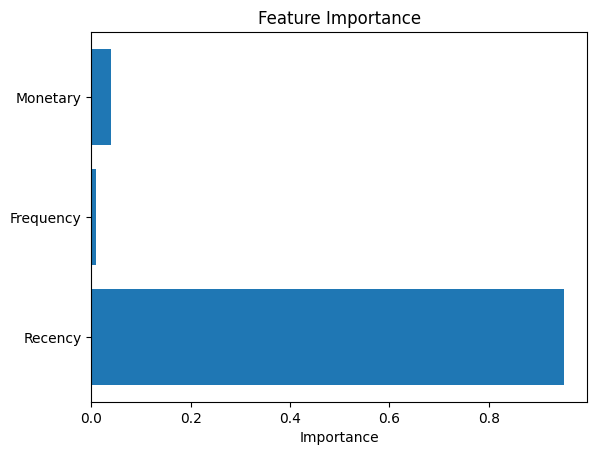

In [14]:
# Feature importance
importances = model.feature_importances_
feature_names = X.columns
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

## 6. Business Recommendations

In [17]:
# Suggest strategies based on insights
print("Business Recommendations:")
print("1. Target users with high Recency values for re-engagement campaigns.")
print("2. Offer promotions to users with moderate Frequency and Monetary scores.")
print("3. Focus retention efforts on categories with high churn risk.")

Business Recommendations:
1. Target users with high Recency values for re-engagement campaigns.
2. Offer promotions to users with moderate Frequency and Monetary scores.
3. Focus retention efforts on categories with high churn risk.
